## Package import and define parameters

Below, you will define the basic parameters for your database and subcellular structures of interest. You will also initialize the tables in your database to hold the data for your objects of interest.

In general, the sections of this notebook can be run separately from each other. However, you'll want to update and run the parameter defining cell before jumping ahead to other sections. If you get an error stating that something has not been defined, it means you probably need to return to the parameters cell and run it. 


In [1]:
## Define database and structural information

# database info
database_name = 'centrosomes'
db_user = "pearlryder"
db_password = ""
db_host = "localhost"

# path to find data

USER_NAME = 'pearlryder'
FILE_PATH = '/Users/' + USER_NAME + '/data/centrosomes-rna-data'


# here you can create a distance threshold that changes with the nuclear cycle
# the expectation is that you have a column in your images table describing the nuclear stage 
# this threshold is optional and describes how close an RNA object can be to your target of interest
# and still be considered a "true" RNA object (instead of background)

distance_threshold_dict = {
'NC10': 15,
'NC11': 14,
'NC12': 13,
'NC13': 12,
'NC14': 10
}

## Calculate cumulative % RNA and % RNA in granules

In this section, we calculate the cumulative distribution of RNA relative to the distance from a subcellular structure of interest. As in the distance measurements section, we define structure_1 as the "object of interest" (in most cases, this will be your RNA data) and structure_2 as the "target object." 

This workflow will calculate the % of total RNA and % of total RNA in granules at 0 microns and then at regular intervals defined by the "step_size" parameter up to the distance threshold, if you choose to use a distance threshold. For example, if distance_threshold = 5 and the step_size = 0.05, then this code will calculate the % RNA and % RNA in granules at 0, 0.05, 0.10, 0.15 microns, etc., up to 5 microns for each image.

If you choose not to define an upper distance threshold, then the % of RNA is calculated at intervals defined by the step size from 0 microns up to the maximum distance_from_structure_2 for each image.


In [3]:
# package import
import psycopg2
import os

# local packages
from pipeline import calculate_percent_distributions
from pipeline import calculate_distributions_by_image
from pipeline import save_csv

In [ ]:
# define parameters

# update the strings that describe your object of interest and target objects
structure_1 = 'rna'
structure_2 = 'centrosomes'

# update the column name in your images table that holds data for your image names
image_name_column = 'name'


# set distance_threshold = None if you want to process the images without a distance threshold
# you do not need quotes around the word None - it is a special word in Python, like True or False
# in microns
distance_threshold = 5

# the step size between % RNA measurements; in microns
step_size = 0.05

# parameters for saving data. Default is to save in the directory containing your raw-data
# and segmentations in a folder named data within a folder named output 

csv_output_dir = os.path.join(FILE_PATH, 'output', 'data')

print("The directory where distribution data will be saved is:\n" + csv_output_dir)

In [ ]:
# make an output directory if it doesn't already exist

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)


In [ ]:
# select images table column names and images data from database

column_name_query = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'images';"

image_name_query = "SELECT * FROM images;"

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()

cur.execute(column_name_query)
column_names =  [column_name[0] for column_name in cur.fetchall()]

cur.execute(image_name_query)
image_data =  cur.fetchall()

cur.close()
conn.close

# process the images data into format needed for rna_distribution calculation
# this will create a list of dictionaries that contain 'column_name' : field
# one row is converted into one dictionary in the list

image_data_list = []

for row_data in image_data:
    image_data_dict = {}
    
    for column_name in column_names:
        idx = column_names.index(column_name)
        
        image_data_dict[column_name] = row_data[idx]
        
    image_data_list.append(image_data_dict)
    
print('The names of the columns in your images table are:\n ' + str(column_names))

In [ ]:
# this cell calculates the percent distribution of total RNA and RNA in granules from 0.0 microns to the 
# distance threshold specified by the user. The data is contained in a dataframe object 

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)

%time rna_distribution_df = calculate_distributions_by_image(image_data_list, distance_threshold, step_size, image_name_column, structure_1, structure_2, conn)

conn.close()

In [ ]:
# this cell reveals the top of the RNA distribution dataframe
# verify that you have the expected columns

rna_distribution_df.head(10)


In [ ]:
# this cell saves the distributions data to a file named distributions.csv 
# in an automatically created "output/data" folder in your data folder
# you can change the name of the file name in the first line of this cell
# this cell WILL NOT overwrite data

distribution_data_filename = 'distributions.csv'

save_csv(distribution_data_filename, csv_output_dir, rna_distribution_df)


## Graph distribution data

Here we graph the data that was saved in the previous cell


In [2]:
# package imports

import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import os


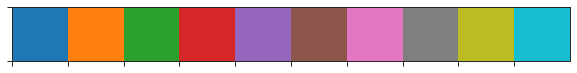

In [9]:
# parameters

distribution_data_filename = 'distributions-distance-th-9.csv'

data_output_dir = os.path.join(FILE_PATH, 'output', 'data')

plots_output_dir =  os.path.join(FILE_PATH, 'output', 'plots')

sns_palette = sns.color_palette()
sns.palplot(sns_palette)

palette_dict = {'gapdh': sns_palette[0], 
                'cen': sns_palette[1], 
                'plp': sns_palette[2],
                'cg14438': sns_palette[3],
               'pins': sns_palette[4],
               'cyclin_b':sns_palette[9]}


In [4]:
# make an output directory if it doesn't already exist

if not os.path.isdir(plots_output_dir):
    os.makedirs(plots_output_dir)



In [5]:
# load data from your csv file. This appraoch allows you to avoid re-calculating the distributions each time you 
# want to plot your data, which is time consuming

rna_distribution_df = pd.read_csv(data_output_dir + '/' + distribution_data_filename)
rna_distribution_df.head(10)

,distance,percent_total_rna,percent_granule_rna,image_id,name,rna,cycle,stage,auto_stage,gapdh_data_separation
0,0.00,53.646283,53.058479,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
1,0.05,53.646283,53.058479,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
2,0.10,56.828273,56.090133,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
3,0.15,59.316629,58.516474,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
4,0.20,59.878040,58.927290,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
5,0.25,63.482577,62.389253,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
6,0.30,63.783681,62.568742,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
7,0.35,64.617388,63.291185,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
8,0.40,65.537347,64.091858,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN
9,0.45,65.832068,64.226410,45,NC12_interphase_Slide005_Emb6_Img1.nd2,cen,interphase,NC12,NC13,NaN


(0.0, 100.0)

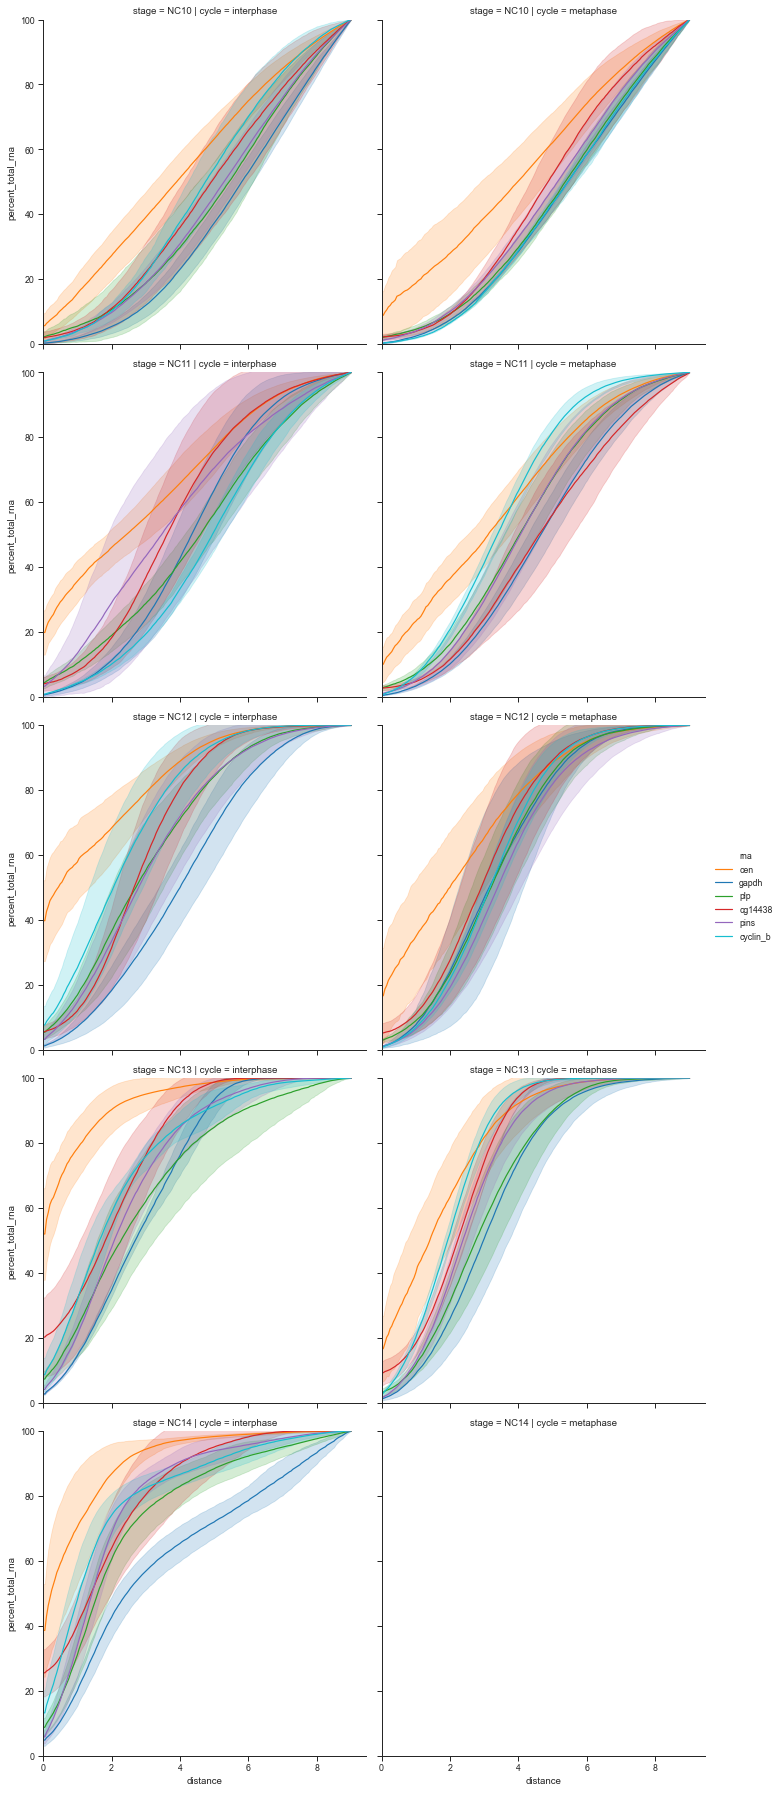

In [10]:
# Here we plot the distribution as mean (dark line) +/- sd (shading) using the Seaborn library and matplotlib
# https://seaborn.pydata.org/examples/index.html
# There are a lot of options in Seaborn. In this example, we separate the plots into columns based on the variable 
# "cycle" and adjust the color using the rna_type, in order to compare our experimental RNA (cen) to control (gapdh)


sns.set_style("ticks")
sns.set_context("paper")
percent_rna_plt = sns.relplot(x = 'distance', 
                              y = 'percent_total_rna', 
                              hue = 'rna', 
                              palette = palette_dict,
                              row='stage',
                              row_order = ['NC10', 'NC11', 'NC12', 'NC13', 'NC14'], 
                              col = 'cycle', 
                              col_order = ['interphase', 'metaphase'], 
                              ci = "sd", 
                              kind="line", 
                              data = rna_distribution_df);

plt.xlim(0)
plt.ylim(0,100)


In [12]:
# Here we define a function to save your plots. We choose to save at 600 dpi as .pdf files, which work well with
# Adobe Illustrator files for figure creation. You can change this function so as desired so that your plots will
# be saved consistently

def save_plot(plot_fn, plots_output_dir, plot):
    """ This function takes two strings as inputs and a matplotlib plot object. plot_fn describes the desired filename
    plots_output_dir is the directory to save the plot. plot is a variable containing your plot
    
    This function will not overwrite data
    
    The function tests if a file exists in the plots_output_dir. If a file exists, it prints a message and does nothing
    If a file does not a exist, the plot is saved
    
    Returns nothing
    """
    
    if os.path.isfile(plots_output_dir + '/' + plot_fn):
        print('Plot already saved and will not be saved again')
    else:
        plot.savefig(plots_output_dir + '/' + plot_fn, bbox_inches = 'tight', dpi = 600, format = 'pdf', transparent = True)
        
    return None


def line_plot(rna_dataframe, y_axis, labels_bool):
    sns.set_style("ticks")
    sns.set_context("paper")
    line_plt = sns.relplot(x = 'distance', 
                                  y = y_axis, 
                                  hue = 'rna', 
                                  palette = palette_dict,
                                  row='stage',
                                  row_order = ['NC10', 'NC11', 'NC12', 'NC13', 'NC14'], 
                                  col = 'cycle', 
                                  col_order = ['interphase', 'metaphase'], 
                                  ci = "sd", 
                                  kind="line", 
                                  data = rna_dataframe);

    plt.xlim(0)
    plt.ylim(0,100)
    
    if not labels_bool:
        for ax in line_plt.axes.flatten():
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title('')
    
    return line_plt
    
    
    
def swarm_plot(rna_dataframe, y_axis): 
    swarm_plt = sns.catplot(data=one_micron_df, 
                x='rna',
                y=y_axis,
                row='stage',
                row_order=['NC10', 'NC11', 'NC12', 'NC13', 'NC14'],
                col='cycle', 
                hue='rna', 
                kind='swarm',
                palette=palette_dict)

    plt.ylim(0,100)

    
    return swarm_plt


In [13]:
# Here we plot the distribution as mean (dark line) +/- sd (shading) using the Seaborn library and matplotlib
# https://seaborn.pydata.org/examples/index.html
# There are a lot of options in Seaborn. In this example, we separate the plots into columns based on the variable 
# "cycle" and adjust the color using the rna_type, in order to compare our experimental RNA (cen) to control (gapdh)

gapdh_data = rna_distribution_df.loc[rna_distribution_df['rna'] == 'gapdh'] 

rna_types = ['cen', 'plp', 'cg14438', 'pins', 'cyclin_b']

for rna_type in rna_types:

    rna_data = rna_distribution_df.loc[rna_distribution_df['rna'] == rna_type] 


    # subset dataframes
    combined_data = pd.concat([rna_data, gapdh_data])
    less_than_1_micron_distribution_df = combined_data.loc[combined_data['distance'] <= 1] 
    one_micron_df = combined_data.loc[combined_data['distance'] == 1]

    # combine into list of dictionaries
    dataframes = [('_all-data',  combined_data), ('_less-than-1', less_than_1_micron_distribution_df)]

    labels_bool_tuple = (True, False)

    y_axis_tuple = ('percent_total_rna', 'percent_granule_rna')

    for y_axis in y_axis_tuple:
        for (data_type, rna_dataframe) in dataframes:
            for labels_bool in labels_bool_tuple:

                if labels_bool == True:
                    label = '_labels_th_9_'
                else:
                    label = '_no_labels_th_9_'

                rna_plt = line_plot(rna_dataframe, y_axis, labels_bool)
                fn = rna_type + data_type + label + y_axis + '.pdf'
                save_plot(fn, plots_output_dir, rna_plt)
                plt.close()

        swarm_plt = swarm_plot(one_micron_df, y_axis)
        fn = rna_type + '_one-micron_' + y_axis + '.pdf'
        save_plot(fn, plots_output_dir, swarm_plt)
        plt.close()


Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again


In [ ]:
# Now use your function to save the plot

percent_total_RNA_fn = 'percent_total_RNA.pdf'

save_plot(percent_total_RNA_fn, plots_output_dir, percent_rna_plt)

In [ ]:
# Now we plot the percent_granule column

sns.set_style("ticks")
sns.set_context("paper")

percent_granule_plt = sns.relplot(x = 'distance', y = 'percent_granule_rna', ci = "sd", hue = 'rna_type',  col = 'cycle', col_order = ['interphase', 'metaphase'], kind="line", data = rna_distribution_df);
plt.xlim(0)
plt.ylim(0,100)


In [ ]:
# save the percent_granule_plot

percent_granule_filename = 'percent_granule_RNA.pdf'

save_plot(percent_granule_filename, plots_output_dir, percent_granule_plt)


In [ ]:
# Subsetting data: we often find that we want to focus our analysis on a particular distance, such as the amount of
# RNA that is closest to the centrosome. For this process, you can subset the RNA distribution dataframe and then 
# repeat the plotting.

# this line creates a new dataframe containing only datapoints where the distance is less than or equal to 1
less_than_1_micron_distribution_df = rna_distribution_df.loc[rna_distribution_df['distance'] <= 1] 

less_than_1_micron_distribution_df.tail()

In [ ]:
# now you can repeat the plots for the % total RNA and % RNA in granules using this new dataframe
# you can see that we changed to data = less_than_1_micron_distribution_df in the sns.relplot line

sns.set_style("ticks")
sns.set_context("paper")
percent_rna_subset_plt = sns.relplot(x = 'distance', y = 'percent_total_rna', hue = 'rna_type', col = 'cycle', col_order = ['interphase', 'metaphase'], ci = "sd", kind="line", data = less_than_1_micron_distribution_df);

plt.xlim(0)
plt.ylim(0,100)



In [ ]:
# Save your plot using your save_plot function

# name your plot:
percent_total_RNA_subset_fn = 'percent_total_RNA_less_than_1_micron.pdf'

save_plot(percent_total_RNA_subset_fn, plots_output_dir, percent_rna_subset_plt)




In [ ]:
# here we're plotting the % RNA in granules for the subset data:

sns.set_style("ticks")
sns.set_context("paper")
percent_granule_subset_plt = sns.relplot(x = 'distance', y = 'percent_granule_rna', hue = 'rna_type', col = 'cycle', col_order = ['interphase', 'metaphase'], ci = "sd", kind="line", data = less_than_1_micron_distribution_df);

plt.xlim(0)
plt.ylim(0,100)



In [ ]:
# and you can save that data if it's not already saved

# name your plot:
percent_granule_subset_fn = 'percent_granule_RNA_less_than_1_micron.pdf'

save_plot(percent_granule_subset_fn, plots_output_dir, percent_granule_subset_plt)


In [ ]:
# Finally, we sometimes find that we want to capture data for a single distance point
# For example, we might want to get all the data points for what % of RNA is located within 1 micron
# To do this, we change the subset to distance == 1
# Since our dataframe contains cumulative distribution data, this point represents the % RNA / % RNA in granules
# within 1 micron

# this line creates a new dataframe containing only datapoints where the distance is equal to 1
one_micron_distribution_df = rna_distribution_df.loc[rna_distribution_df['distance'] == 1] 

# verify that the distance column is all 1.0
one_micron_distribution_df.head()

In [ ]:
# This cell will plot the percent of RNA at 1 micron as a dot plot with an overlaying box plot 

ax = sns.swarmplot(x = 'rna_type', y = 'percent_total_rna', hue = 'rna_type', dodge = False, data = one_micron_distribution_df)
ax = sns.boxplot(x = 'rna_type', y = 'percent_total_rna', color = "0.25", showbox = True, fliersize = 0, dodge = False, data = one_micron_distribution_df)

# make the boxplot clear and the boundaries black
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
    
# set the y axis from 0 to 100
plt.ylim(0,100)

# make the x and y axes visible w/o the top and right frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# remove the legend frame
plt.legend(frameon=False)

subset_one_micron_total_RNA_df = ax.get_figure()


In [ ]:
# Here you can save that data if it's not already saved

# name your plot:
subset_one_micron_total_RNA_fn = 'percent_total_RNA_at_1_micron.pdf'

save_plot(subset_one_micron_total_RNA_fn, plots_output_dir, subset_one_micron_total_RNA_df)


In [ ]:
# Now we repeat the same plotting and saving for the percent granule column:

ax = sns.swarmplot(x = 'rna_type', y = 'percent_granule_rna', hue = 'rna_type', dodge = False, data = one_micron_distribution_df)
ax = sns.boxplot(x = 'rna_type', y = 'percent_granule_rna', color = "0.25", showbox = True, fliersize = 0, dodge = False, data = one_micron_distribution_df)

# make the boxplot clear and the boundaries black
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
    
# set the y axis from 0 to 100
plt.ylim(0,100)

# make the x and y axes visible w/o the top and right frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# remove the legend frame
plt.legend(frameon=False)

subset_one_micron_granule_RNA_df = ax.get_figure()


In [ ]:
# And we can save the granule plot

# name your plot:
subset_one_micron_granule_RNA_fn = 'percent_granule_RNA_at_1_micron.pdf'

save_plot(subset_one_micron_granule_RNA_fn, plots_output_dir, subset_one_micron_granule_RNA_df)


## Save database tables as .csv files

This section gives you the option to save your database tables as .csv files, which allows you to view raw object data using a text editor rather than needing to have a specialized program like postgres.

By default, the data will be saved in the output/db_backups/db_csvs folder. You can change this behavior in the parameters cell

In [ ]:
# package import

import psycopg2
from psycopg2 import sql 
import os


In [ ]:
# parameters 

db_csv_output_dir =  os.path.join(FILE_PATH, 'output', 'db_backups', 'db_csvs')

In [ ]:
# make folders to contain csv files if they do not already exist 

if not os.path.isdir(db_csv_output_dir):
    os.makedirs(db_csv_output_dir)


In [ ]:
# this cell gets the names of the tables you created from the postgres database

select_tables_sql = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';"

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()
cur.execute(select_tables_sql)
table_name_raw = cur.fetchall()
cur.close()
conn.close()

table_names = [table_name[0] for table_name in table_name_raw]

In [ ]:
# this cell copies data from those tables into csv files
# it will overwrite your previously saved files

for table_name in table_names:
    table_fn = table_name + '.csv'
    table_path = os.path.join(db_csv_output_dir, table_fn)

    copy_sql_query = sql.SQL("COPY {table_name} TO STDOUT WITH CSV HEADER").format(table_name = sql.Identifier(table_name))

    conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
    cur = conn.cursor()


    with open(table_path, 'w') as f_output:
        cur.copy_expert(copy_sql_query, f_output)